In [316]:
# https://www.kaggle.com/datasets/haseebindata/student-performance-predictions

In [317]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [318]:
from fastai.vision.all import *
from fastbook import *
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from fastai.optimizer import SGD

In [319]:
csvFile = pd.read_csv('.data/student_performance.csv')
csvFile

,StudentID,Name,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade
0,1,John,Male,85,15,78,1,High,80
1,2,Sarah,Female,90,20,85,2,Medium,87
2,3,Alex,Male,78,10,65,0,Low,68
3,4,Michael,Male,92,25,90,3,High,92
4,5,Emma,Female,88,18,82,2,Medium,85
5,6,Olivia,Female,95,30,88,1,High,90
6,7,Daniel,Male,70,8,60,0,Low,62
7,8,Sophia,Female,85,17,77,1,Medium,78
8,9,James,Male,82,12,70,2,Low,72
9,10,Isabella,Female,91,22,86,3,High,88


In [320]:
len(csvFile)

10

In [321]:
csvFile['ParentalSupport'] = pd.Categorical(csvFile['ParentalSupport'], categories=['Low', 'Medium', 'High'], ordered=True)

In [322]:
csvFile = csvFile.drop(columns=['Name', 'StudentID'])

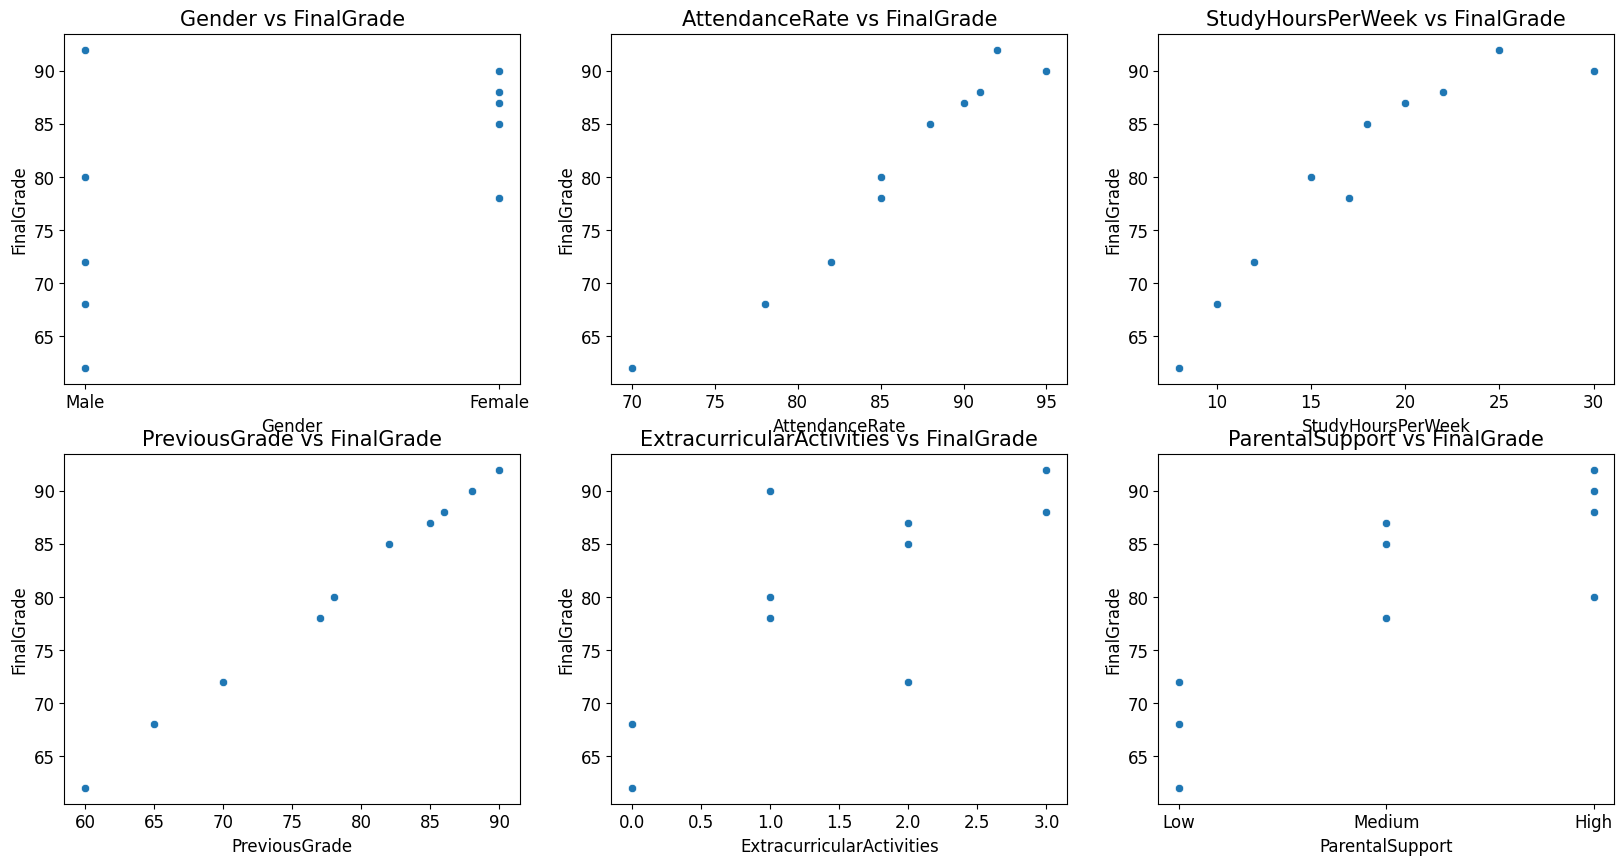

In [323]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i, column in enumerate(csvFile.columns[:-1]):
    sns.scatterplot(x=csvFile[column], y=csvFile['FinalGrade'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(f'{column} vs FinalGrade', fontsize=15)

# plt.tight_layout()
plt.show()


In [324]:
grouped_stats = csvFile.groupby('Gender')['FinalGrade'].describe()
grouped_stats

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,5.0,85.6,4.615192,78.0,85.0,87.0,88.0,90.0
Male,5.0,74.8,11.627553,62.0,68.0,72.0,80.0,92.0


In [325]:
print(csvFile.drop(columns=['FinalGrade']).dtypes)

Gender                         object
AttendanceRate                  int64
StudyHoursPerWeek               int64
PreviousGrade                   int64
ExtracurricularActivities       int64
ParentalSupport              category
dtype: object


In [326]:
csvFile['Gender'] = pd.Categorical(csvFile['Gender']).codes
csvFile['ParentalSupport'] = pd.Categorical(csvFile['ParentalSupport']).codes

In [327]:
x = torch.tensor(csvFile.drop(columns=['FinalGrade']).values, dtype=torch.float32)
y = torch.tensor(csvFile['FinalGrade'].values, dtype=torch.float32)
x[:5], y[:5]

(tensor([[ 1., 85., 15., 78.,  1.,  2.],
         [ 0., 90., 20., 85.,  2.,  1.],
         [ 1., 78., 10., 65.,  0.,  0.],
         [ 1., 92., 25., 90.,  3.,  2.],
         [ 0., 88., 18., 82.,  2.,  1.]]),
 tensor([80., 87., 68., 92., 85.]))

In [328]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [329]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([8, 6]), torch.Size([2, 6]), torch.Size([8]), torch.Size([2]))

In [330]:
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=6, shuffle=True)
valid_dl = DataLoader(TensorDataset(X_val, y_val), batch_size=6, shuffle=True)
dls = DataLoaders(train_dl, valid_dl)

In [339]:
simple_net = nn.Sequential(
    nn.Linear(6,120),
    nn.ReLU(),
    nn.Linear(120,1)
)

In [340]:
loss_func = nn.MSELoss()

In [341]:
def batch_accuracy(preds, targets):
    return (preds - targets).mean().abs()

In [342]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=loss_func, metrics=batch_accuracy)
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,4315482207289344.000000,340535810195456.000000,18453612.000000,00:00
1,2256278927704064.000000,139483508899840.000000,11810314.000000,00:00
2,1513189053300736.000000,57132451889152.000000,7558601.000000,00:00
3,1124068371726336.000000,23401456467968.000000,4837505.000000,00:00
4,884875401887744.000000,9585238736896.000000,3096003.750000,00:00
5,723550725996544.000000,3926113386496.000000,1981442.250000,00:00
6,607762300010496.000000,1608139145216.000000,1268124.250000,00:00
7,520814176763904.000000,658692767744.000000,811598.875000,00:00
8,453233738776576.000000,269798899712.000000,519421.687500,00:00
9,399263381061632.000000,110508728320.000000,332428.531250,00:00
